In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from scipy.interpolate import interp1d
import sys
import seaborn as sns
from sklearn.preprocessing import normalize

module_name_bmn = "Dyn_BMN"
file_path_bmn = "/content/drive/MyDrive/Balloon_model/Dyn_BMN.py"
module_name_noise = "noise"
file_path_noise = "/content/drive/MyDrive/Balloon_model/noise.py"

#BalloonModelNet

def load_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module
#
dyn_bmn = load_module_from_path(module_name_bmn, file_path_bmn)
noise = load_module_from_path(module_name_noise, file_path_noise)

# Data experiment 1

This code generates two groups. The first group will have 7 different connectivity states and the second group will have only 5 of these states:
* Number of simulations (n_subjects):
  * Group 1: 50 subjects
  * Group 2: 50 subjects
* TR = 2 s
* Number of point (T): 300
* Number of ROIs (D): 30 / 90 AAL
* Number of states (S):
  * Group 1: 7 states
  * Group 2: 5 states (sample of 7 states)

* Transition Probability matrix (P): The same for both groups



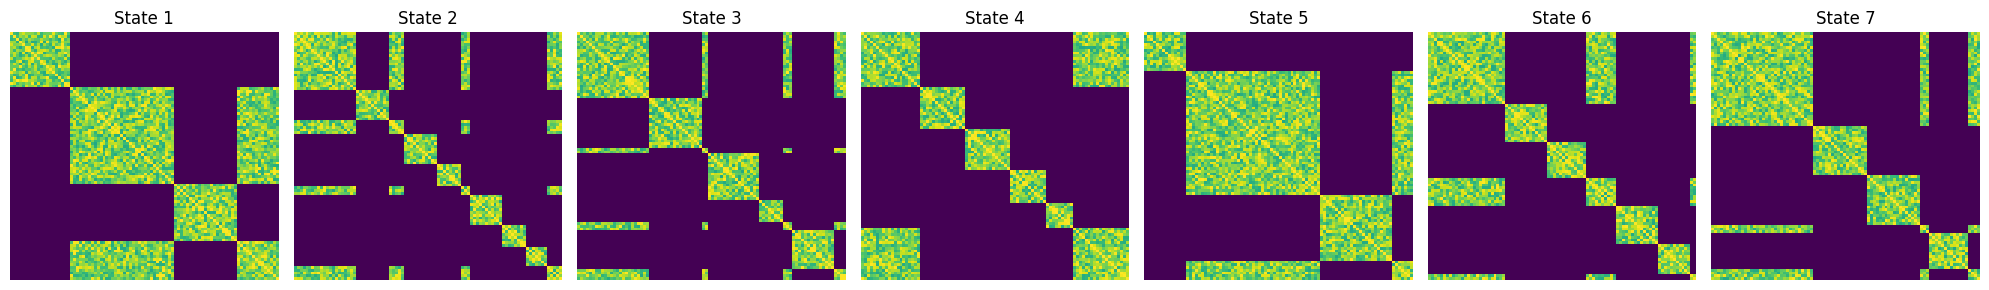

In [ ]:
# Generation of states
D = 90
S = 7
#States of Group 1
#FC_states1 = dyn_bmn.gen_states_A(S, D, N_conns=[10,15,20,12,10,5,12], sym=True, seed=40) #30 ROIs
#FC_states1 = dyn_bmn.gen_states_A(S, D, N_conns=[5,4,10,4,6,4,8], sym=True, seed=12) # 10 ROIs
FC_states1 = dyn_bmn.gen_states_modular_A(S, D, n_modules=(4,9), intra_range=(0.6,1.0),
                                          n_extra_per_module=50,
                                          sym=True,
                                          seed=42)
# Visualize the matrices in FC_states1
fig, axes = plt.subplots(1, len(FC_states1), figsize=(20, 3))
for i, state_matrix in enumerate(FC_states1):
    sns.heatmap(state_matrix, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f'State {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#plt.title("FC matrices of states")
plt.tight_layout()
plt.show()


In [ ]:
import os

# Create a folder
save_dir = "/content/drive/MyDrive/Balloon_model/Data1"
os.makedirs(save_dir, exist_ok=True)

# timeline
TR = 2.0
T  = 300
timeline = np.arange(0, T*TR, TR)     # N_pts = T

n_subjects1 = 200
#n_subjects2 = 50


dur_params1 = [(4,5,8),(4,6,9),(5,7,9),(4,6,7),(4,5,6),(4,5,6),(4,6,8)] # Vidaurre et al "Brain network dynamics are hierarchically organized in time", 2017

# States of Group 2

FC_states2 = FC_states1[:5]
dur_params2 = dur_params1[:5]

# gen_network_stimulus_by_states parameters
nblocks_default = 7
duration_stimulus_per_state = [(1,3)]*S ############
sep_bwn_ons = 7#################

#Transition matrix################################

P = np.array([[0. , 0.21, 0.22, 0.18, 0.21, 0.1, 0.08],
    [0.1, 0., 0.27, 0.17, 0.09, 0.2, 0.17],
    [0.12, 0.16, 0., 0.27, 0.09, 0.19, 0.17],
    [0.13, 0.18, 0.26, 0., 0.11, 0.12, 0.2],
    [0.11, 0.18, 0.12, 0.15, 0. , 0.17, 0.27],
    [0.13, 0.18, 0.12, 0.21, 0.12, 0. ,  0.24],
    [0.18, 0.18, 0.17, 0.17, 0.11, 0.19, 0.  ]])

rng = np.random.default_rng(100)

for j in range(2):
  print(f"GROUP {j+1}")
  if j == 0:
    FC_states = FC_states1
    dur_params = dur_params1

    save_dir = "/content/drive/MyDrive/Balloon_model/Data1/Group1"
    os.makedirs(save_dir, exist_ok=True)


  else:
    FC_states = FC_states2
    P = P[:5,:5]
    P = normalize(P, axis=1, norm='l1')
    S = 5
    dur_params = dur_params2
    save_dir = "/content/drive/MyDrive/Balloon_model/Data1/Group2"
    os.makedirs(save_dir, exist_ok=True)

  for i in range(n_subjects1):
      if ((j==0) or ((i<169) and (j==1))): # This part is only for run the code if it has been interrupted
          _ = int(rng.choice(np.arange(1, 10000, 1)))
          print(f"Skipping subject {i+1}")

          continue

      print(f"Generating Subject {i+1}...")


      seed = int(rng.choice(np.arange(1, 10000, 1)))

      sample, states_dur, segments_indx_by_states = dyn_bmn.gen_state_sequence(timeline, S=S,P=P, dur_params=dur_params, time_offset=10, seed=seed)
      U, meta = dyn_bmn.gen_network_stimulus_by_states(timeline = timeline, states=sample, N_nds=D,
                                                      FC_states = FC_states,
                                                      nblocks_default=nblocks_default,
                                                      segments_indx_by_states = segments_indx_by_states,
                                                      duration_stimulus_per_state = duration_stimulus_per_state,
                                                      sep_bwn_ons=sep_bwn_ons,
                                                      time_offset=10,
                                                      seed=seed)

      BalloonNetwork = dyn_bmn.Dyn_BalloonModelNetwork(timeline, U, sample, FC_states, states_dur, P=P,TR=TR)

      #filename = f"group{j+1}_subj{i:03d}.npz" #30 ROIs
      filename = f"{D}ROIgroup{j+1}_subj{i+1:03d}.npz"
      filepath = os.path.join(save_dir, filename)

      # Save the file
      np.savez_compressed(filepath, **BalloonNetwork)
      print(f"Complete")

print(f"\n Files saved in {save_dir}")


GROUP 1
Skipping subject 1
Skipping subject 2
Skipping subject 3
Skipping subject 4
Skipping subject 5
Skipping subject 6
Skipping subject 7
Skipping subject 8
Skipping subject 9
Skipping subject 10
Skipping subject 11
Skipping subject 12
Skipping subject 13
Skipping subject 14
Skipping subject 15
Skipping subject 16
Skipping subject 17
Skipping subject 18
Skipping subject 19
Skipping subject 20
Skipping subject 21
Skipping subject 22
Skipping subject 23
Skipping subject 24
Skipping subject 25
Skipping subject 26
Skipping subject 27
Skipping subject 28
Skipping subject 29
Skipping subject 30
Skipping subject 31
Skipping subject 32
Skipping subject 33
Skipping subject 34
Skipping subject 35
Skipping subject 36
Skipping subject 37
Skipping subject 38
Skipping subject 39
Skipping subject 40
Skipping subject 41
Skipping subject 42
Skipping subject 43
Skipping subject 44
Skipping subject 45
Skipping subject 46
Skipping subject 47
Skipping subject 48
Skipping subject 49
Skipping subject 50
S

# Experimento 1 alternativo

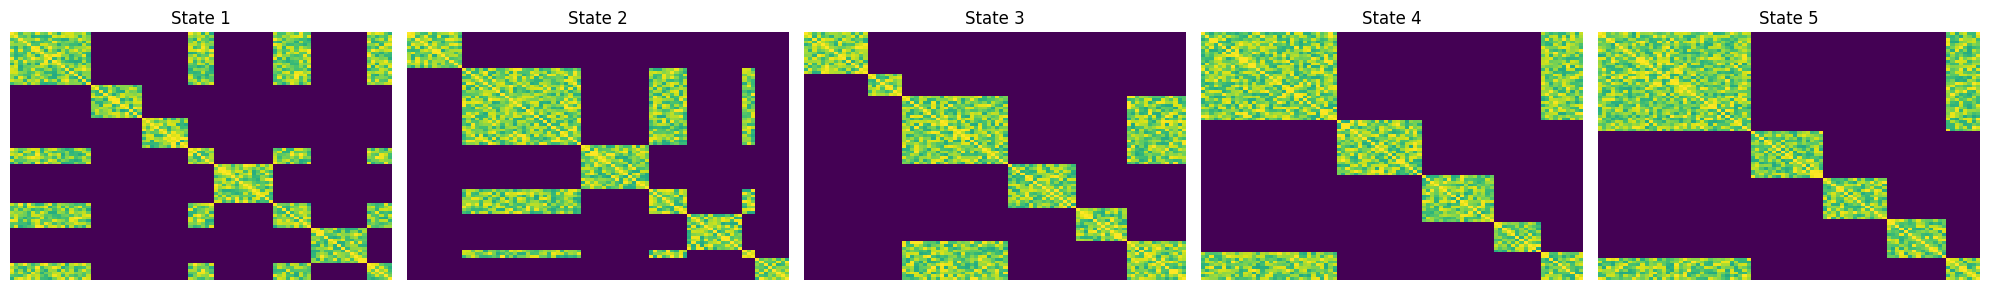

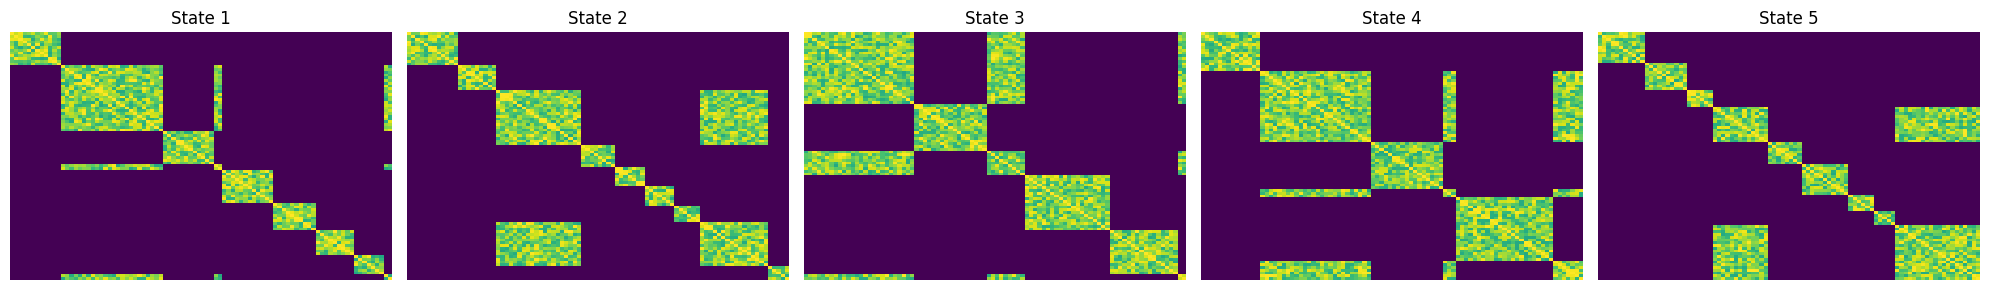

In [3]:
# Generation of states
D = 90
S = 5
#States of Group 1
#FC_states1 = dyn_bmn.gen_states_A(S, D, N_conns=[10,15,20,12,10,5,12], sym=True, seed=40) #30 ROIs
#FC_states1 = dyn_bmn.gen_states_A(S, D, N_conns=[5,4,10,4,6,4,8], sym=True, seed=12) # 10 ROIs
FC_states1 = dyn_bmn.gen_states_modular_A(S, D, n_modules=(5,6), intra_range=(0.6,1.0),
                                          n_extra_per_module=50,
                                          sym=True,
                                          seed=60)

FC_states2 = dyn_bmn.gen_states_modular_A(S, D, n_modules=(4,9), intra_range=(0.6,1.0),
                                          n_extra_per_module=50,
                                          sym=True,
                                          seed=50)
# Visualize the matrices in FC_states1
fig, axes = plt.subplots(1, len(FC_states1), figsize=(20, 3))
for i, state_matrix in enumerate(FC_states1):
    sns.heatmap(state_matrix, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f'State {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#plt.title("FC matrices of states")
plt.tight_layout()
plt.show()

# Visualize the matrices in FC_states2
fig, axes = plt.subplots(1, len(FC_states2), figsize=(20, 3))
for i, state_matrix in enumerate(FC_states2):
    sns.heatmap(state_matrix, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f'State {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#plt.title("FC matrices of states")
plt.tight_layout()
plt.show()

In [4]:
import os

# Create a folder
save_dir = "/content/drive/MyDrive/Balloon_model/Data1_2"
os.makedirs(save_dir, exist_ok=True)

# timeline
TR = 2.0
T  = 300
timeline = np.arange(0, T*TR, TR)     # N_pts = T

n_subjects1 = 200
#n_subjects2 = 50


dur_params = [(5,6,7)]*S

# gen_network_stimulus_by_states parameters
nblocks_default = 7
duration_stimulus_per_state = [(1,3)]*S ############
sep_bwn_ons = 7#################

#Transition matrix################################

# Transition matrix with no atractors
P = np.ones([5,5])
np.fill_diagonal(P,0)
P = normalize(P, axis=1, norm='l1')
rng = np.random.default_rng(100)

for j in range(2):
  print(f"GROUP {j+1}")
  if j == 0:
    FC_states = FC_states1

    save_dir = "/content/drive/MyDrive/Balloon_model/Data1_2/Group1"
    os.makedirs(save_dir, exist_ok=True)


  else:
    FC_states = FC_states2
    save_dir = "/content/drive/MyDrive/Balloon_model/Data1_2/Group2"
    os.makedirs(save_dir, exist_ok=True)

  for i in range(n_subjects1):
      if ((j==0) or((j==1) and (i<195))): # This part is only for run the code if it has been interrupted
          _ = int(rng.choice(np.arange(1, 10000, 1)))
          print(f"Skipping subject {i+1}")

          continue

      print(f"Generating Subject {i+1}...")


      seed = int(rng.choice(np.arange(1, 10000, 1)))

      sample, states_dur, segments_indx_by_states = dyn_bmn.gen_state_sequence(timeline, S=S,P=P, dur_params=dur_params, time_offset=10, seed=seed)
      U, meta = dyn_bmn.gen_network_stimulus_by_states(timeline = timeline, states=sample, N_nds=D,
                                                      FC_states = FC_states,
                                                      nblocks_default=nblocks_default,
                                                      segments_indx_by_states = segments_indx_by_states,
                                                      duration_stimulus_per_state = duration_stimulus_per_state,
                                                      sep_bwn_ons=sep_bwn_ons,
                                                      time_offset=10,
                                                      seed=seed)

      BalloonNetwork = dyn_bmn.Dyn_BalloonModelNetwork(timeline, U, sample, FC_states, states_dur, P=P,TR=TR)

      #filename = f"group{j+1}_subj{i:03d}.npz" #30 ROIs
      filename = f"{D}_2_ROIgroup{j+1}_subj{i+1:03d}.npz"
      filepath = os.path.join(save_dir, filename)

      # Save the file
      np.savez_compressed(filepath, **BalloonNetwork)
      print(f"Complete")

print(f"\n Files saved in {save_dir}")


GROUP 1
Skipping subject 1
Skipping subject 2
Skipping subject 3
Skipping subject 4
Skipping subject 5
Skipping subject 6
Skipping subject 7
Skipping subject 8
Skipping subject 9
Skipping subject 10
Skipping subject 11
Skipping subject 12
Skipping subject 13
Skipping subject 14
Skipping subject 15
Skipping subject 16
Skipping subject 17
Skipping subject 18
Skipping subject 19
Skipping subject 20
Skipping subject 21
Skipping subject 22
Skipping subject 23
Skipping subject 24
Skipping subject 25
Skipping subject 26
Skipping subject 27
Skipping subject 28
Skipping subject 29
Skipping subject 30
Skipping subject 31
Skipping subject 32
Skipping subject 33
Skipping subject 34
Skipping subject 35
Skipping subject 36
Skipping subject 37
Skipping subject 38
Skipping subject 39
Skipping subject 40
Skipping subject 41
Skipping subject 42
Skipping subject 43
Skipping subject 44
Skipping subject 45
Skipping subject 46
Skipping subject 47
Skipping subject 48
Skipping subject 49
Skipping subject 50
S

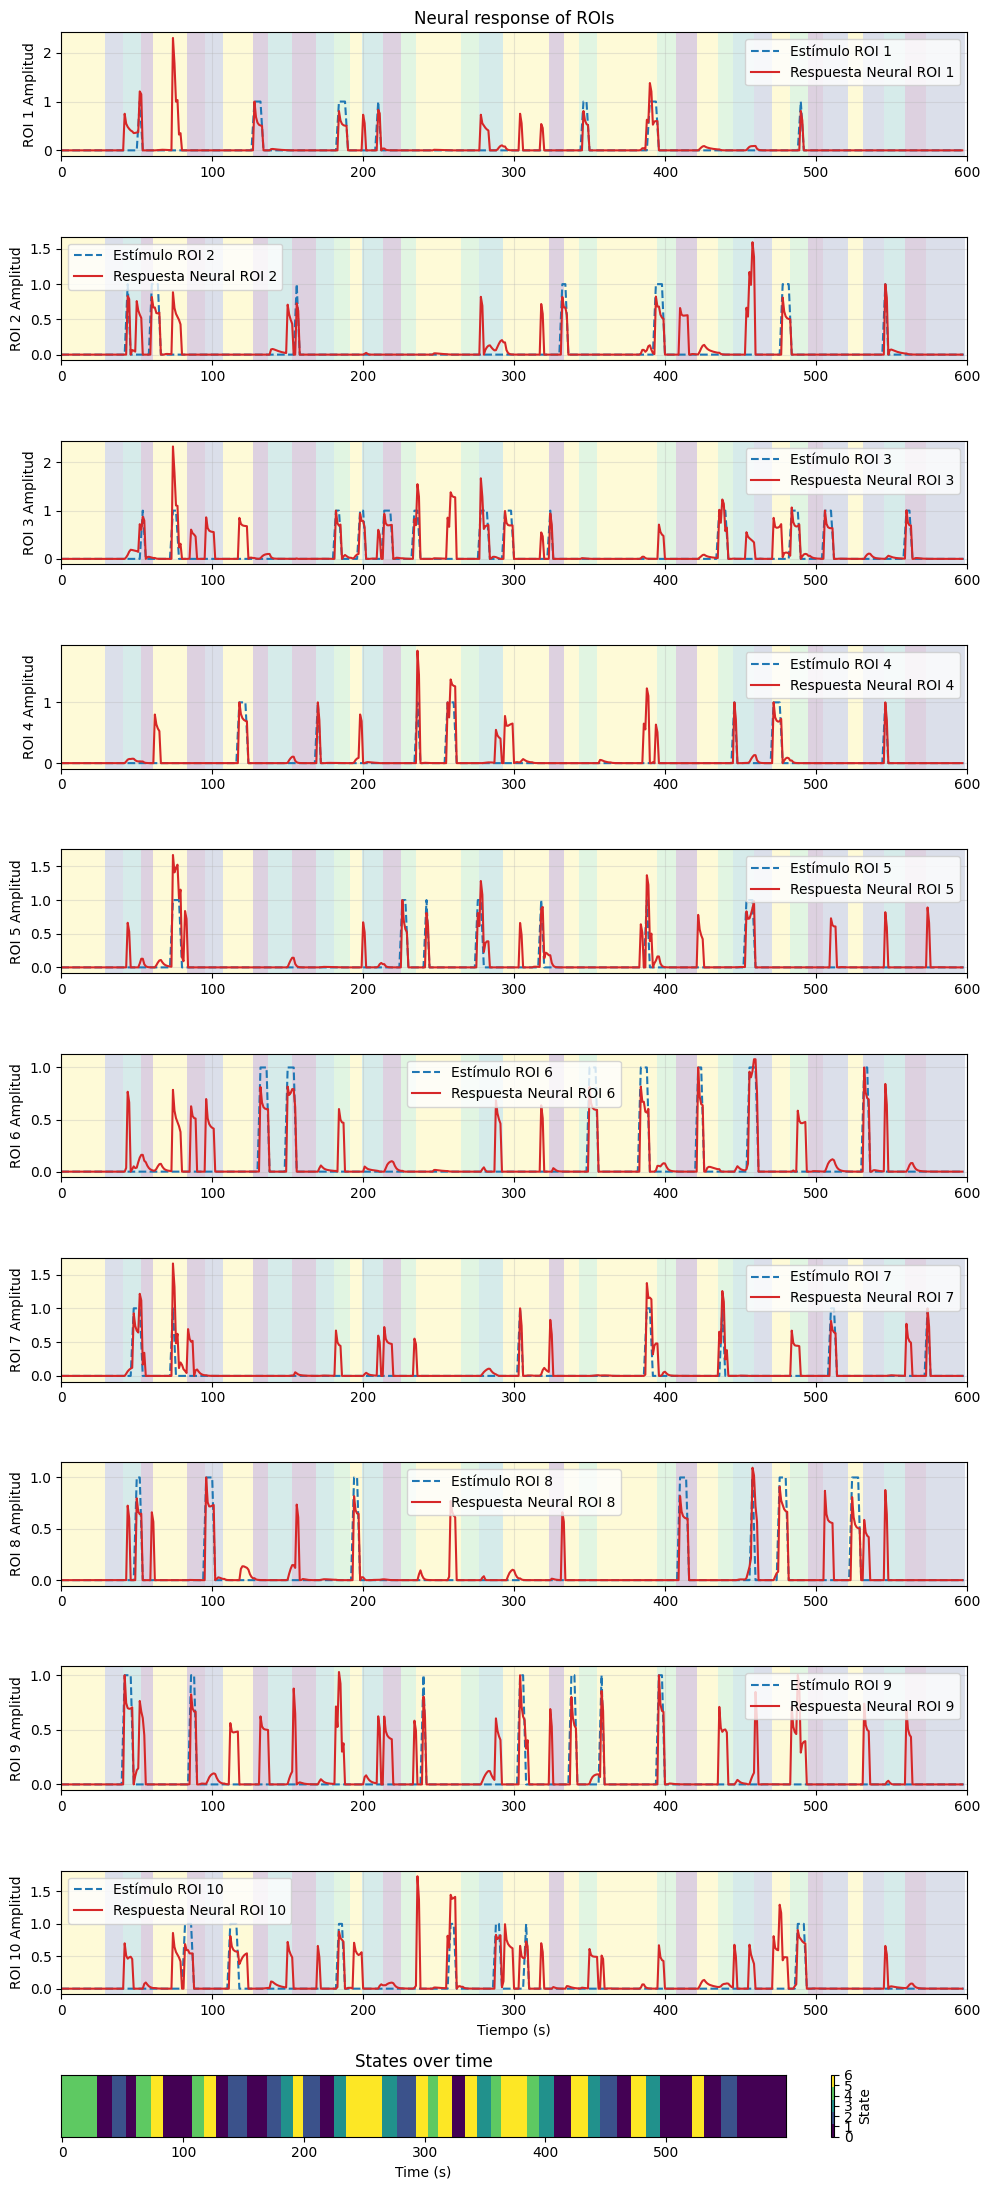

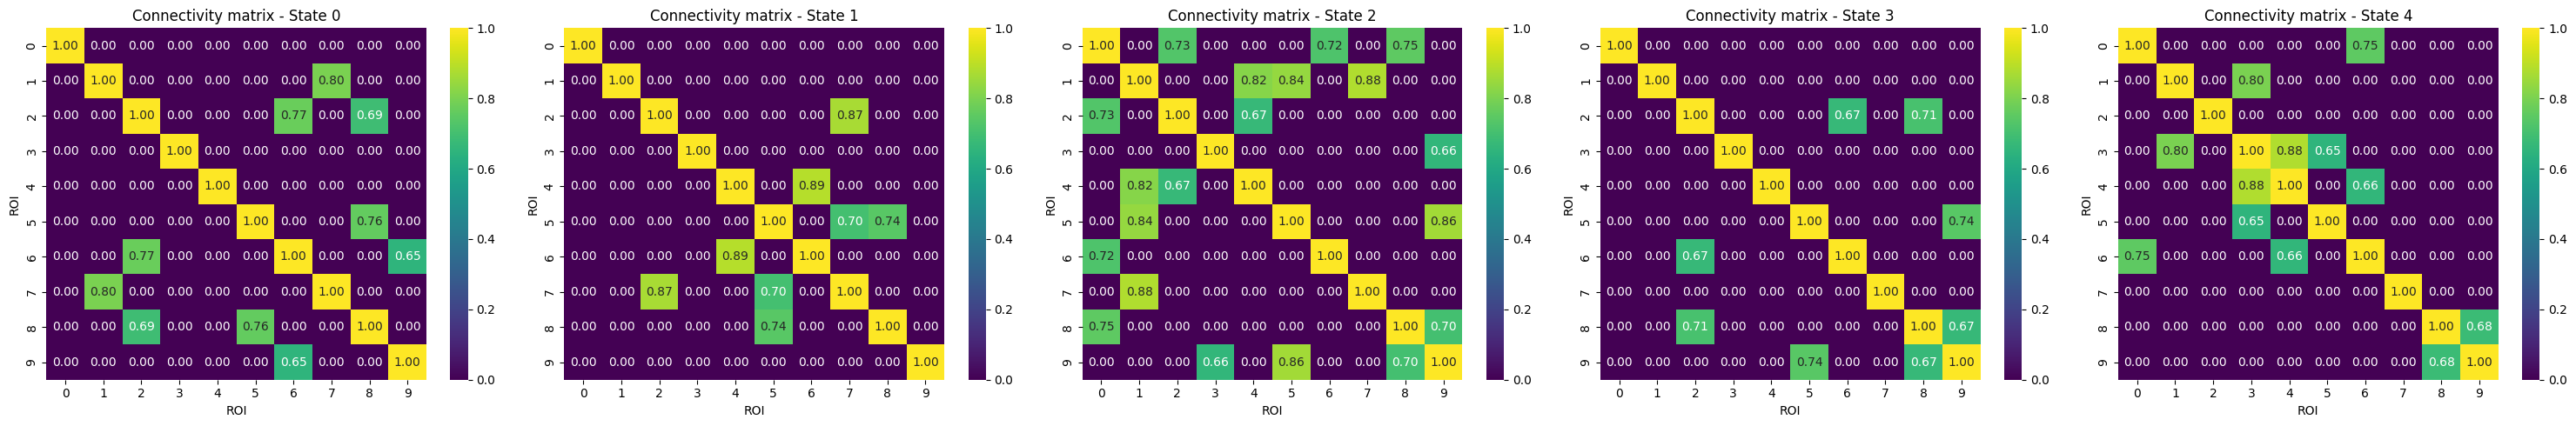

In [ ]:
bold = BalloonNetwork['bold']
neur = BalloonNetwork["neur"]
tbold = BalloonNetwork['tbold']
tneur = BalloonNetwork['tneur']
dyn_bmn.plot_signal_states(timeline, tsignal=tneur, signal = neur, D=D, S=S, FC_states=FC_states, sample=sample, TR=2, alpha=0.18, zorder=0, U=U, mode = "neur", shift=2)

(298, 10)


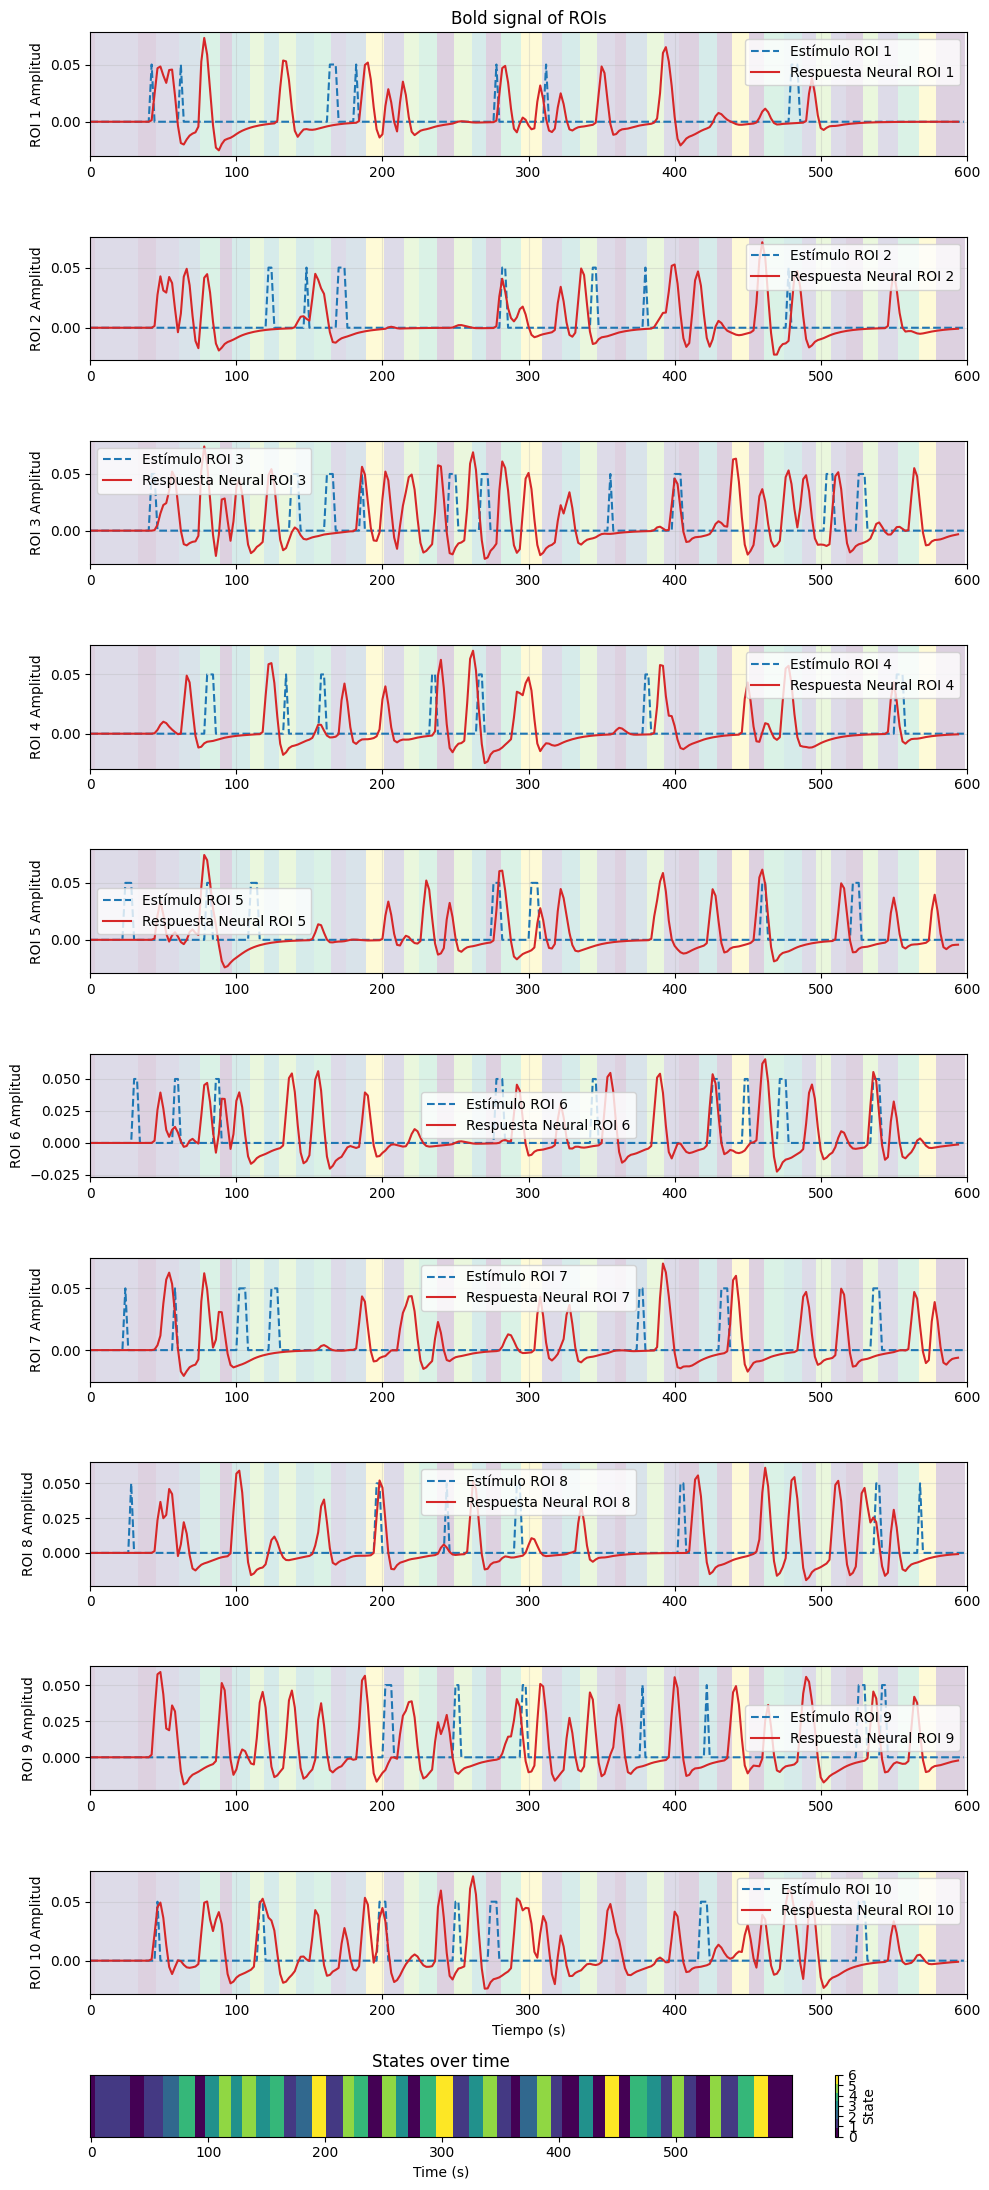

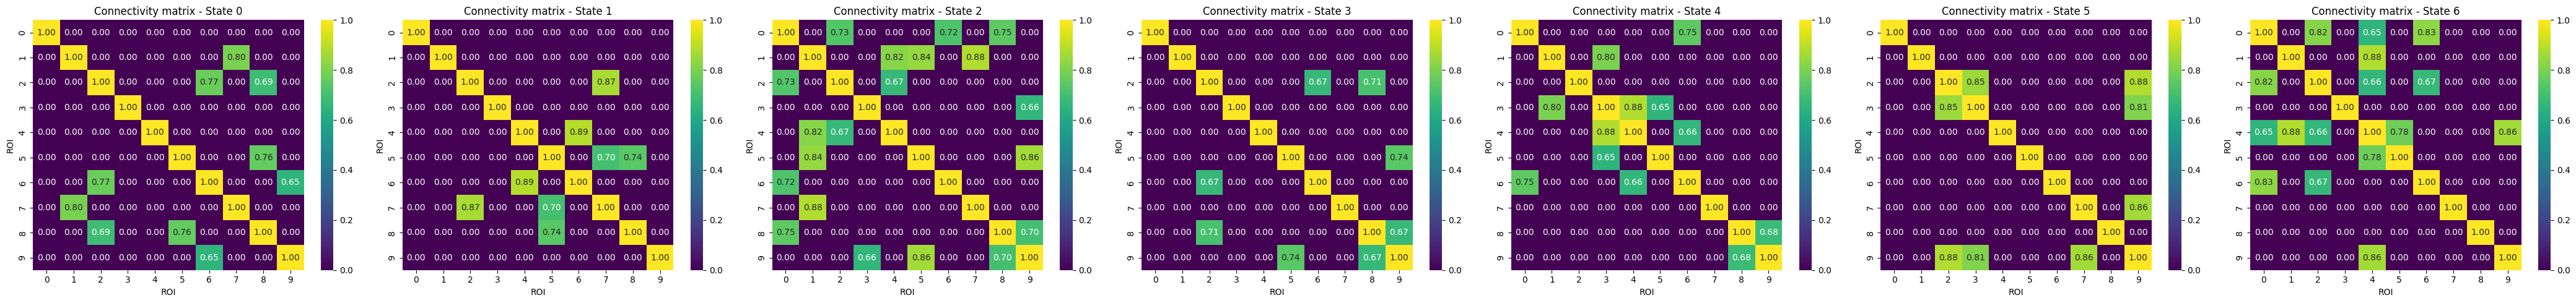

In [ ]:
dyn_bmn.plot_signal_states(timeline, tsignal=tbold[:,0], signal = bold, D=D, S=S, FC_states=FC_states, sample=sample, TR=2, alpha=0.18, zorder=0, U=U*0.05, mode = "bold", shift=2)

# Data experiment 2

This code generates two groups with the same states of conectiviy, but with diferent dwell times:
* Number of simulations (n_subjects):
  * Group 1: 50 subjects
  * Group 2: 50 subjects
* TR = 2 s
* Number of point (T): 300
* Number of ROIs (D): 30
* Number of states (S): 7
* Dwell times: The second group will have shorter dwell times than the other group.
* Transition Probability matrix: The same for both groups



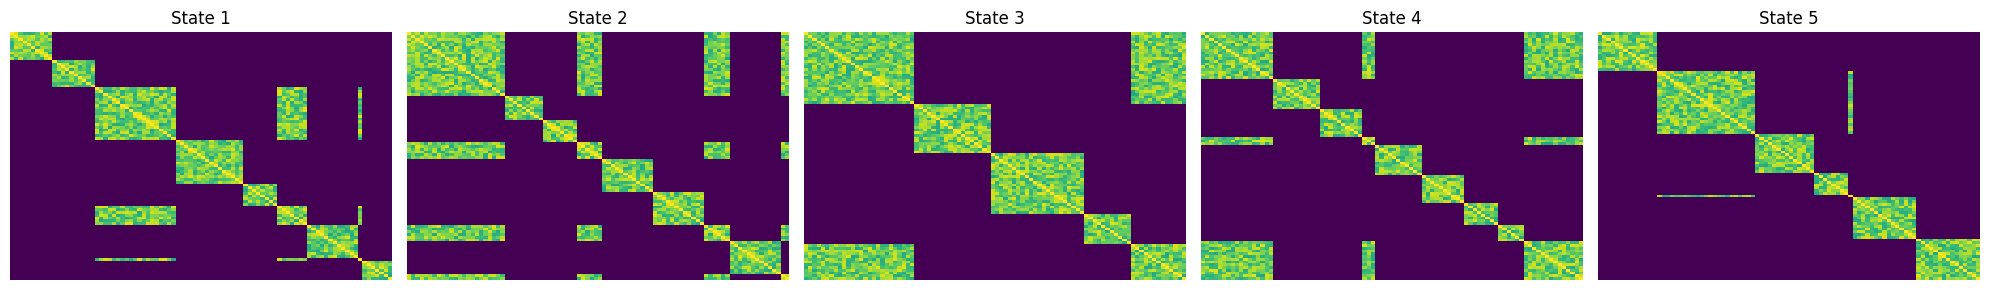

In [ ]:
# Generation of states
# D = 30 #30 ROIs
# D = 10 # 10 ROIs
D = 90
S = 5
#States of Group 1
# FC_states = dyn_bmn.gen_states_A(S, D, N_conns=[10,15,20,12,10,5,12], sym=True, seed=40) # 30 ROIs
# FC_states = dyn_bmn.gen_states_A(S, D, N_conns=[5,4,10,4,6,4,8], sym=True, seed=12) # 10 ROIs
FC_states = dyn_bmn.gen_states_modular_A(S, D, n_modules=(4,9), intra_range=(0.6,0.95), # 90 ROIs
                                          n_extra_per_module=50,
                                          sym=True,
                                          seed=42)

# Visualize the matrices in FC_states1
fig, axes = plt.subplots(1, len(FC_states), figsize=(20, 3))
for i, state_matrix in enumerate(FC_states):
    sns.heatmap(state_matrix, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f'State {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#plt.title("FC matrices of states")
plt.tight_layout()
plt.show()


In [ ]:
import os

# Create a folder
save_dir = "/content/drive/MyDrive/Balloon_model/Data2"
os.makedirs(save_dir, exist_ok=True)

# timeline
TR = 2.0
T  = 300
timeline = np.arange(0, T*TR, TR)     # N_pts = T

n_subjects1 = 200
n_subjects2 = 50

# Dwell times
# Longer
#dur_params1 = [(4,5,8),(4,6,9),(5,7,9),(5,6,7),(5,6,9),(4,6,7),(4,6,8)] # Vidaurre et al "Brain network dynamics are hierarchically organized in time", 2017
dur_params1 = [(5,7,9)]*7
# Shorter
dur_params2 = [(4,5,6)]*7
# States of Group 2

# gen_network_stimulus_by_states parameters
nblocks_default = 7
duration_stimulus_per_state = [(1,3)]*S ############
sep_bwn_ons = 7#################

#Transition matrix################################

# P = np.array([[0. , 0.21, 0.22, 0.18, 0.21, 0.1, 0.08],
#     [0.1, 0., 0.27, 0.17, 0.09, 0.2, 0.17],
#     [0.12, 0.16, 0., 0.27, 0.09, 0.19, 0.17],
#     [0.13, 0.18, 0.26, 0., 0.11, 0.12, 0.2],
#     [0.11, 0.18, 0.12, 0.15, 0. , 0.17, 0.27],
#     [0.13, 0.18, 0.12, 0.21, 0.12, 0. ,  0.24],
#     [0.18, 0.18, 0.17, 0.17, 0.11, 0.19, 0.  ]])

# Transition matrix with no atractors
P = np.ones([5,5])
np.fill_diagonal(P,0)
P = normalize(P, axis=1, norm='l1')

rng = np.random.default_rng(42)
for j in range(2):
  print(f"GROUP {j+1}")
  if j == 0:
    dur_params = dur_params1
    save_dir = "/content/drive/MyDrive/Balloon_model/Data2/Group1"
    os.makedirs(save_dir, exist_ok=True)


  else:
    dur_params = dur_params2
    save_dir = "/content/drive/MyDrive/Balloon_model/Data2/Group2"
    os.makedirs(save_dir, exist_ok=True)

  for i in range(n_subjects1):

      if ((j==0) or ((j==1) and (i<128))): # This part is only for run the code if it has been interrupted
          _ = int(rng.choice(np.arange(1, 10000, 1)))
          print(f"Skipping subject {i+1}")

          continue

      print(f"Generating Subject {i+1}...")
      seed = int(rng.choice(np.arange(1, 10000, 1)))
      sample, states_dur, segments_indx_by_states = dyn_bmn.gen_state_sequence(timeline, S=S,P=P, dur_params=dur_params, time_offset=10, seed=seed)
      U, meta = dyn_bmn.gen_network_stimulus_by_states(timeline = timeline, states=sample, N_nds=D,
                                                      FC_states = FC_states,
                                                      nblocks_default=nblocks_default,
                                                      segments_indx_by_states = segments_indx_by_states,
                                                      duration_stimulus_per_state = duration_stimulus_per_state,
                                                      sep_bwn_ons=sep_bwn_ons,
                                                      time_offset=10,
                                                      seed=seed)

      BalloonNetwork = dyn_bmn.Dyn_BalloonModelNetwork(timeline, U, sample, FC_states, states_dur, TR=TR, P=P)

      #filename = f"d2group{j}_subj{i:03d}.npz" # 40 ROIs
      #filename = f"10ROIgroup{j+1}_subj{i+1:03d}.npz" # 10 ROIs
      filename = f"{D}ROIgroup{j+1}_subj{i+1:03d}.npz"
      filepath = os.path.join(save_dir, filename)

      # Save the file
      np.savez_compressed(filepath, **BalloonNetwork)

print(f"\n Files saved in {save_dir}")


GROUP 1
Skipping subject 1
Skipping subject 2
Skipping subject 3
Skipping subject 4
Skipping subject 5
Skipping subject 6
Skipping subject 7
Skipping subject 8
Skipping subject 9
Skipping subject 10
Skipping subject 11
Skipping subject 12
Skipping subject 13
Skipping subject 14
Skipping subject 15
Skipping subject 16
Skipping subject 17
Skipping subject 18
Skipping subject 19
Skipping subject 20
Skipping subject 21
Skipping subject 22
Skipping subject 23
Skipping subject 24
Skipping subject 25
Skipping subject 26
Skipping subject 27
Skipping subject 28
Skipping subject 29
Skipping subject 30
Skipping subject 31
Skipping subject 32
Skipping subject 33
Skipping subject 34
Skipping subject 35
Skipping subject 36
Skipping subject 37
Skipping subject 38
Skipping subject 39
Skipping subject 40
Skipping subject 41
Skipping subject 42
Skipping subject 43
Skipping subject 44
Skipping subject 45
Skipping subject 46
Skipping subject 47
Skipping subject 48
Skipping subject 49
Skipping subject 50
S

# Data experiment 3

This code generates two groups with diferences in their transition probability matrix:
* Number of simulations (n_subjects):
  * Group 1: 50 subjects
  * Group 2: 50 subjects
* TR = 2 s
* Number of point (T): 300
* Number of ROIs (D): 30
* Number of states (S): 7
* Transition Probability matrix: The first group will have a matrix with attractors, and the second will have a single-value matrix



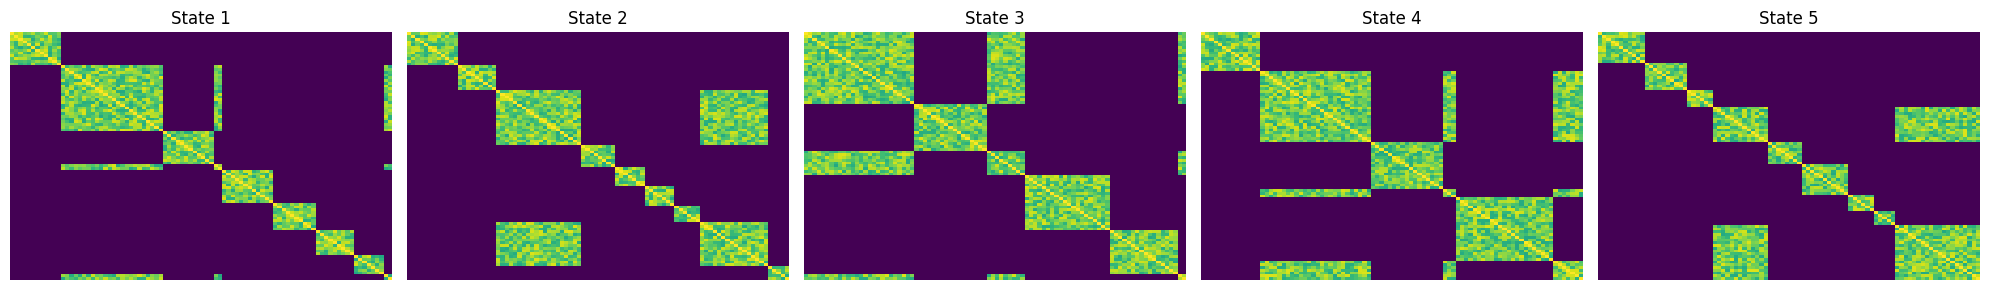

In [ ]:
# Generation of states
#D = 30 #30 ROIs
D = 90 #10 ROIs
S = 5
#States of Group 1
#FC_states = dyn_bmn.gen_states_A(S, D, N_conns=[10,15,20,12,10,5,12], sym=True, seed=40) # 30 ROIs
#FC_states = dyn_bmn.gen_states_A(S, D, N_conns=[5,4,10,4,6,4,8], sym=True, seed=12) # 10 ROIs
FC_states = dyn_bmn.gen_states_modular_A(S, D, n_modules=(4,9), intra_range=(0.6,0.95), # 90 ROIs
                                          n_extra_per_module=50,
                                          sym=True,
                                          seed=50)


# Visualize the matrices in FC_states1
fig, axes = plt.subplots(1, len(FC_states), figsize=(20, 3))
for i, state_matrix in enumerate(FC_states):
    sns.heatmap(state_matrix, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f'State {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#plt.title("FC matrices of states")
plt.tight_layout()
plt.show()


In [ ]:
import os

# Create a folder
save_dir = "/content/drive/MyDrive/Balloon_model/Data3"
os.makedirs(save_dir, exist_ok=True)

# timeline
TR = 2.0
T  = 300
timeline = np.arange(0, T*TR, TR)     # N_pts = T

n_subjects1 = 200
n_subjects2 = 50

# Dwell times
# Longer
#dur_params = [(4,5,8),(4,6,9),(5,7,9),(5,6,7),(5,6,9),(4,6,7),(4,6,8)] # Vidaurre et al "Brain network dynamics are hierarchically organized in time", 2017
dur_params1 = [(4,5,6),(4,5,6),(5,8,9),(4,5,6),(4,5,6)] # The state 3 is the atractor
dur_params2 = [(4,5,6)]*5
# States of Group 2

# gen_network_stimulus_by_states parameters
nblocks_default = 7
duration_stimulus_per_state = [(1,3)]*S
sep_bwn_ons = 7

#Transition matrices

P1 = np.ones([5,5])
P1[:,2] = 2
np.fill_diagonal(P1,0)
P1 = normalize(P1, axis=1, norm='l1')

# Transition matrix with no atractors
P2 = np.ones([5,5])
np.fill_diagonal(P2,0)
P2 = normalize(P2, axis=1, norm='l1')


rng = np.random.default_rng(42)
for j in range(2):
  print(f"GROUP {j+1}")
  if j == 0:
    P = P1
    save_dir = "/content/drive/MyDrive/Balloon_model/Data3/Group1"
    os.makedirs(save_dir, exist_ok=True)
    dur_params = dur_params1

  else:
    P = P2
    save_dir = "/content/drive/MyDrive/Balloon_model/Data3/Group2"
    os.makedirs(save_dir, exist_ok=True)
    dur_params = dur_params2

  for i in range(n_subjects1):
      if ((j==0) or ((j==1)and(i<134))): # This part is only for run the code if it has been interrupted
          _ = int(rng.choice(np.arange(1, 10000, 1)))
          print(f"Skipping subject {i+1}")

          continue

      print(f"Generating Subject {i+1}...")
      seed = int(rng.choice(np.arange(1, 10000, 1)))
      sample, states_dur, segments_indx_by_states = dyn_bmn.gen_state_sequence(timeline, S=S,P=P, dur_params=dur_params, time_offset=10, seed=seed)
      U, meta = dyn_bmn.gen_network_stimulus_by_states(timeline = timeline, states=sample, N_nds=D,
                                                      FC_states = FC_states,
                                                      nblocks_default=nblocks_default,
                                                      segments_indx_by_states = segments_indx_by_states,
                                                      duration_stimulus_per_state = duration_stimulus_per_state,
                                                      sep_bwn_ons=sep_bwn_ons,
                                                      time_offset=10,
                                                      seed=seed)

      BalloonNetwork = dyn_bmn.Dyn_BalloonModelNetwork(timeline, U, sample, FC_states, states_dur, TR=TR,P=P)

      #filename = f"d3group{j}_subj{i:03d}.npz" # 30 ROIs
      filename = f"{D}ROIgroup{j+1}_subj{i+1:03d}.npz"
      filepath = os.path.join(save_dir, filename)

      # Save the file
      np.savez_compressed(filepath, **BalloonNetwork)

print(f"\n Files saved in {save_dir}")


GROUP 1
Skipping subject 1
Skipping subject 2
Skipping subject 3
Skipping subject 4
Skipping subject 5
Skipping subject 6
Skipping subject 7
Skipping subject 8
Skipping subject 9
Skipping subject 10
Skipping subject 11
Skipping subject 12
Skipping subject 13
Skipping subject 14
Skipping subject 15
Skipping subject 16
Skipping subject 17
Skipping subject 18
Skipping subject 19
Skipping subject 20
Skipping subject 21
Skipping subject 22
Skipping subject 23
Skipping subject 24
Skipping subject 25
Skipping subject 26
Skipping subject 27
Skipping subject 28
Skipping subject 29
Skipping subject 30
Skipping subject 31
Skipping subject 32
Skipping subject 33
Skipping subject 34
Skipping subject 35
Skipping subject 36
Skipping subject 37
Skipping subject 38
Skipping subject 39
Skipping subject 40
Skipping subject 41
Skipping subject 42
Skipping subject 43
Skipping subject 44
Skipping subject 45
Skipping subject 46
Skipping subject 47
Skipping subject 48
Skipping subject 49
Skipping subject 50
S

# Pruebas varias

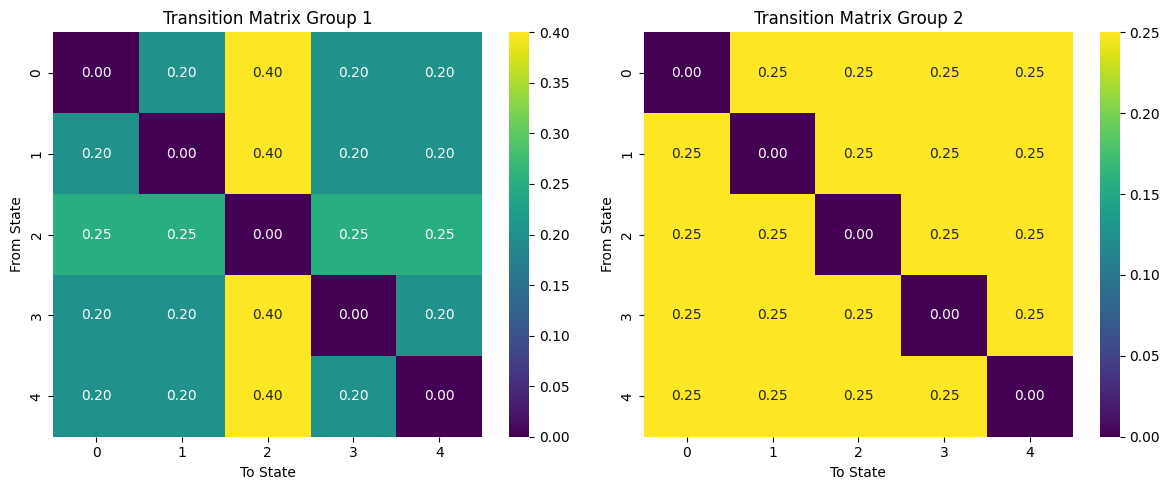

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Transition matrix with attractors
P1 = np.ones([5,5])
P1[:,2] = 2
np.fill_diagonal(P1,0)
P1 = normalize(P1, axis=1, norm='l1')


# Transition matrix with no atractors
P2 = np.ones([5,5])
np.fill_diagonal(P2,0)
P2 = normalize(P2, axis=1, norm='l1')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(P1, ax=axes[0], annot=True, cmap='viridis', fmt=".2f")
axes[0].set_title('Transition Matrix Group 1')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')

sns.heatmap(P2, ax=axes[1], annot=True, cmap='viridis', fmt=".2f")
axes[1].set_title('Transition Matrix Group 2')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')

plt.tight_layout()
plt.show()

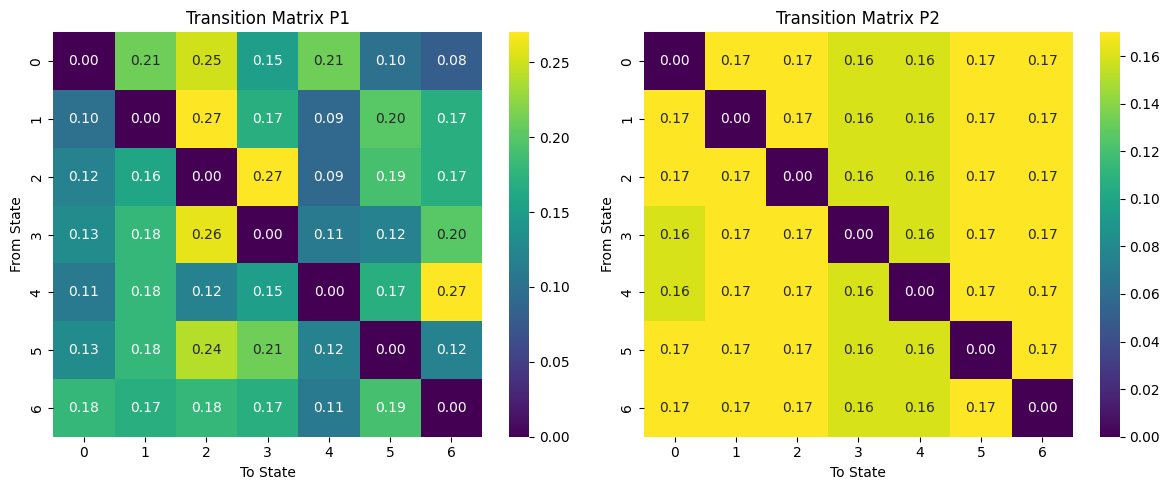

In [ ]:
P1 = np.array([[0. , 0.21, 0.25, 0.15, 0.21, 0.1, 0.08],
    [0.1, 0., 0.27, 0.17, 0.09, 0.2, 0.17],
    [0.12, 0.16, 0., 0.27, 0.09, 0.19, 0.17],
    [0.13, 0.18, 0.26, 0., 0.11, 0.12, 0.2],
    [0.11, 0.18, 0.12, 0.15, 0. , 0.17, 0.27],
    [0.13, 0.18, 0.24, 0.21, 0.12, 0. ,  0.12],
    [0.18, 0.17, 0.18, 0.17, 0.11, 0.19, 0.  ]])

P2 = np.array([[0. , 0.17, 0.17, 0.16, 0.16, 0.17, 0.17],
    [0.17 , 0., 0.17, 0.16, 0.16, 0.17, 0.17],
    [0.17 , 0.17, 0. , 0.16, 0.16, 0.17, 0.17],
    [0.16 , 0.17, 0.17, 0., 0.16, 0.17, 0.17],
    [0.16 , 0.17, 0.17, 0.16, 0., 0.17, 0.17],
    [0.17 , 0.17, 0.17, 0.16, 0.16, 0., 0.17],
    [0.17 , 0.17, 0.17, 0.16, 0.16, 0.17, 0.]])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(P1, ax=axes[0], annot=True, cmap='viridis', fmt=".2f")
axes[0].set_title('Transition Matrix P1')
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')

sns.heatmap(P2, ax=axes[1], annot=True, cmap='viridis', fmt=".2f")
axes[1].set_title('Transition Matrix P2')
axes[1].set_xlabel('To State')
axes[1].set_ylabel('From State')

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np

# Path
folder = "/content/drive/MyDrive/Balloon_model/Data3/Group2"

# List of .npz files
files = [f for f in os.listdir(folder) if f.startswith("10ROI") and f.endswith(".npz")]
files.sort()  # opcional, para orden alfabético

# load all the files
data_list = []
for file in files:
    path = os.path.join(folder, file)
    with np.load(path, allow_pickle=True) as data:
        data_list.append({k: data[k] for k in data.files})

print(f"{len(data_list)} archivos cargados correctamente.")
#print(data_list[0])

50 archivos cargados correctamente.


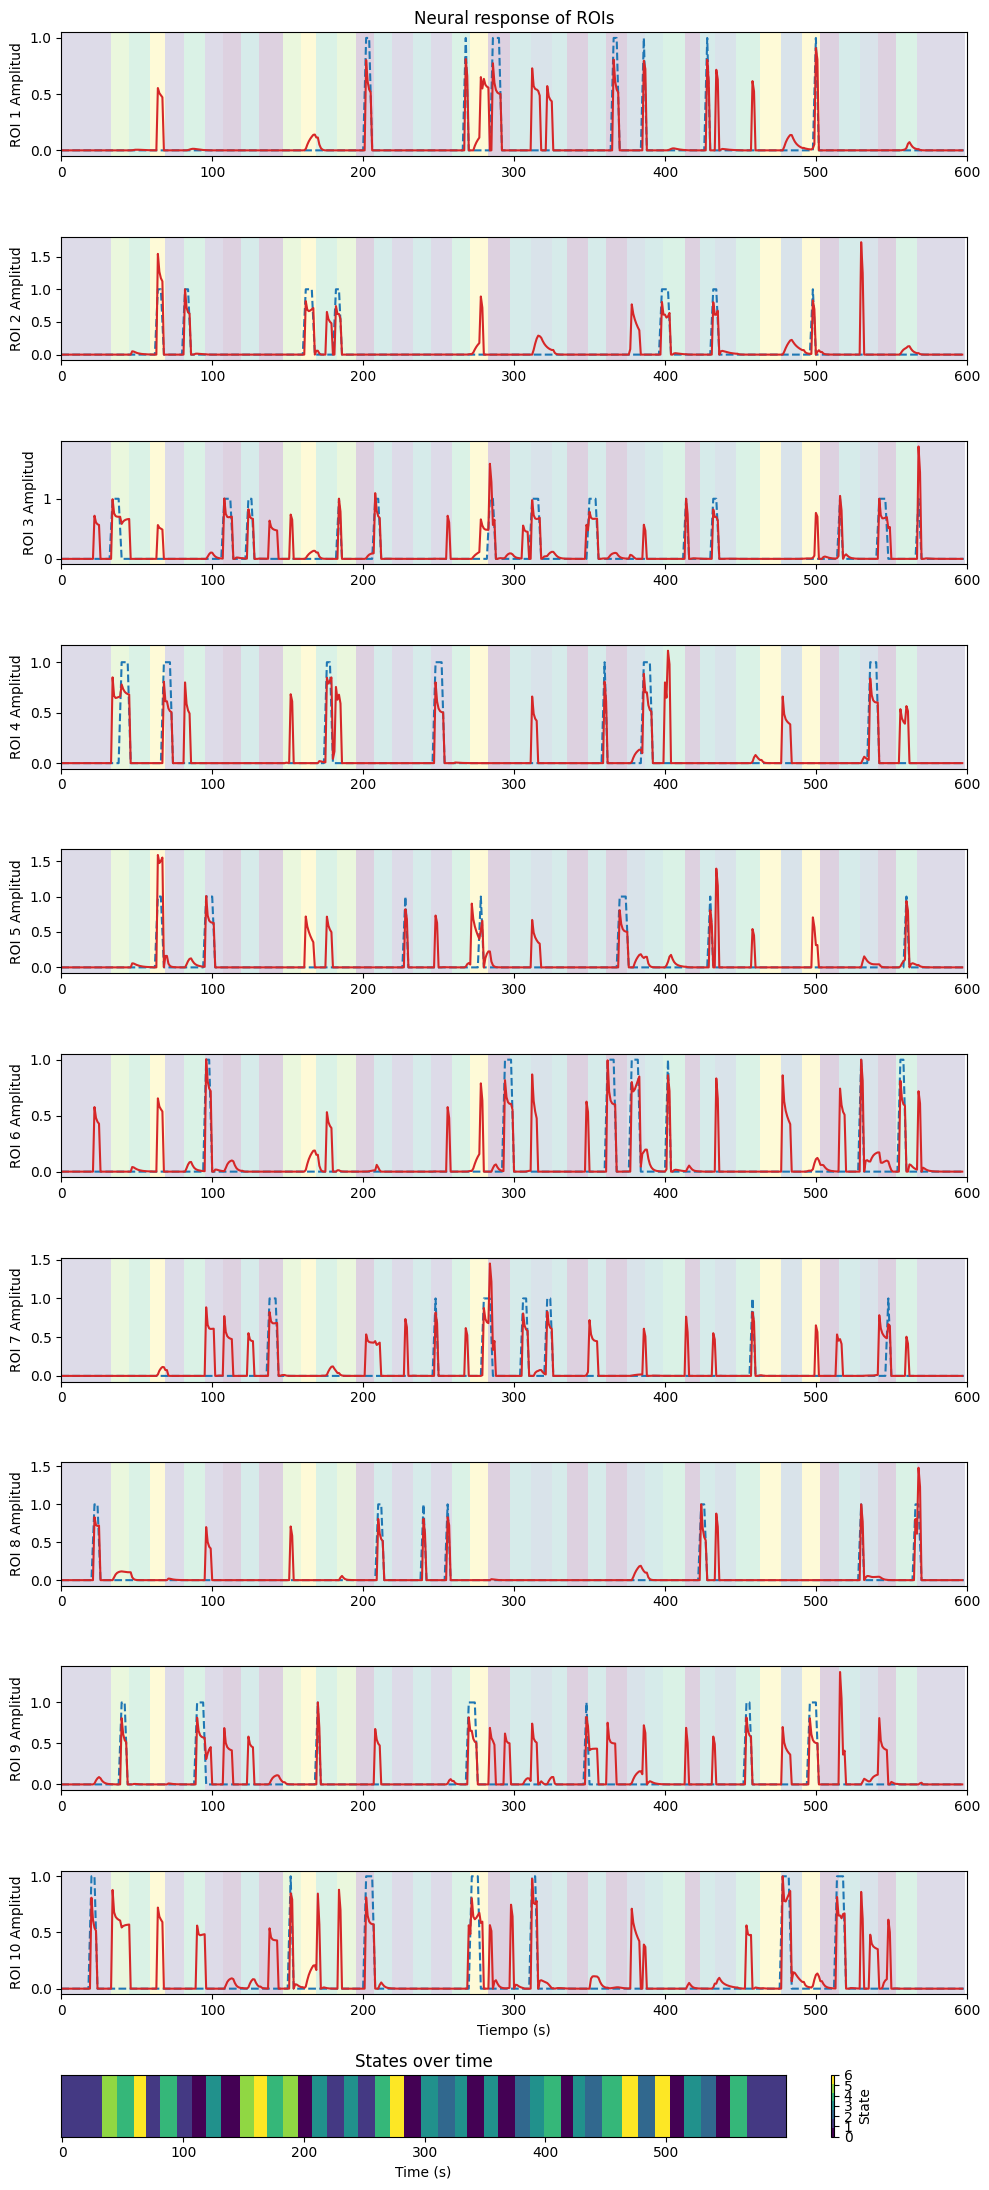

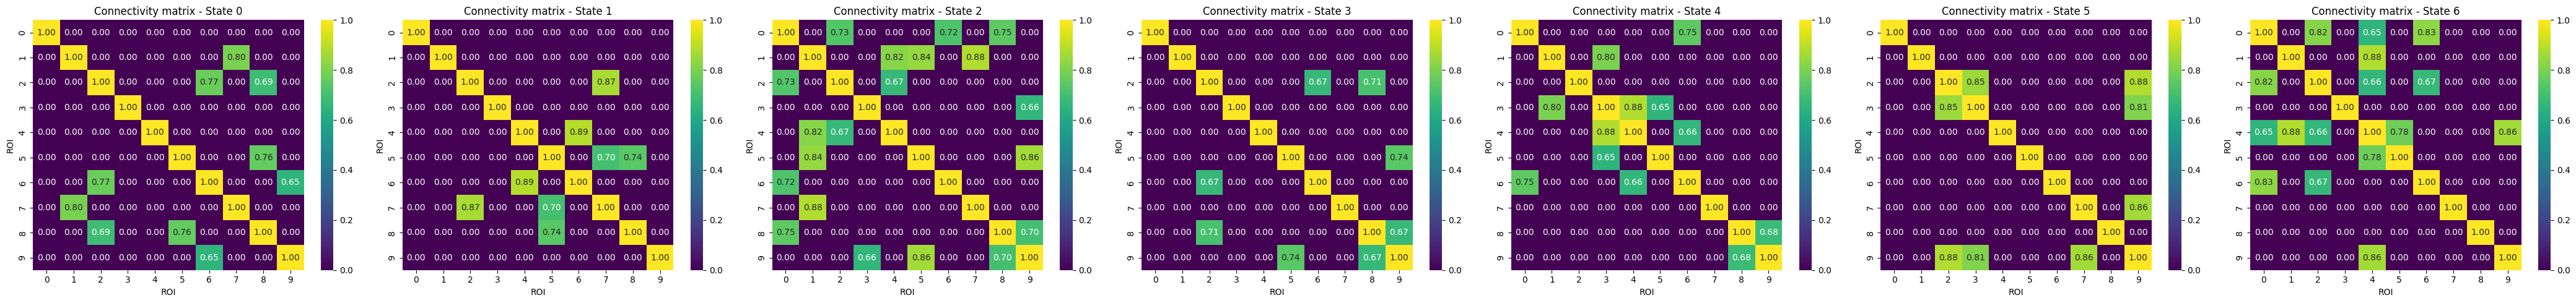

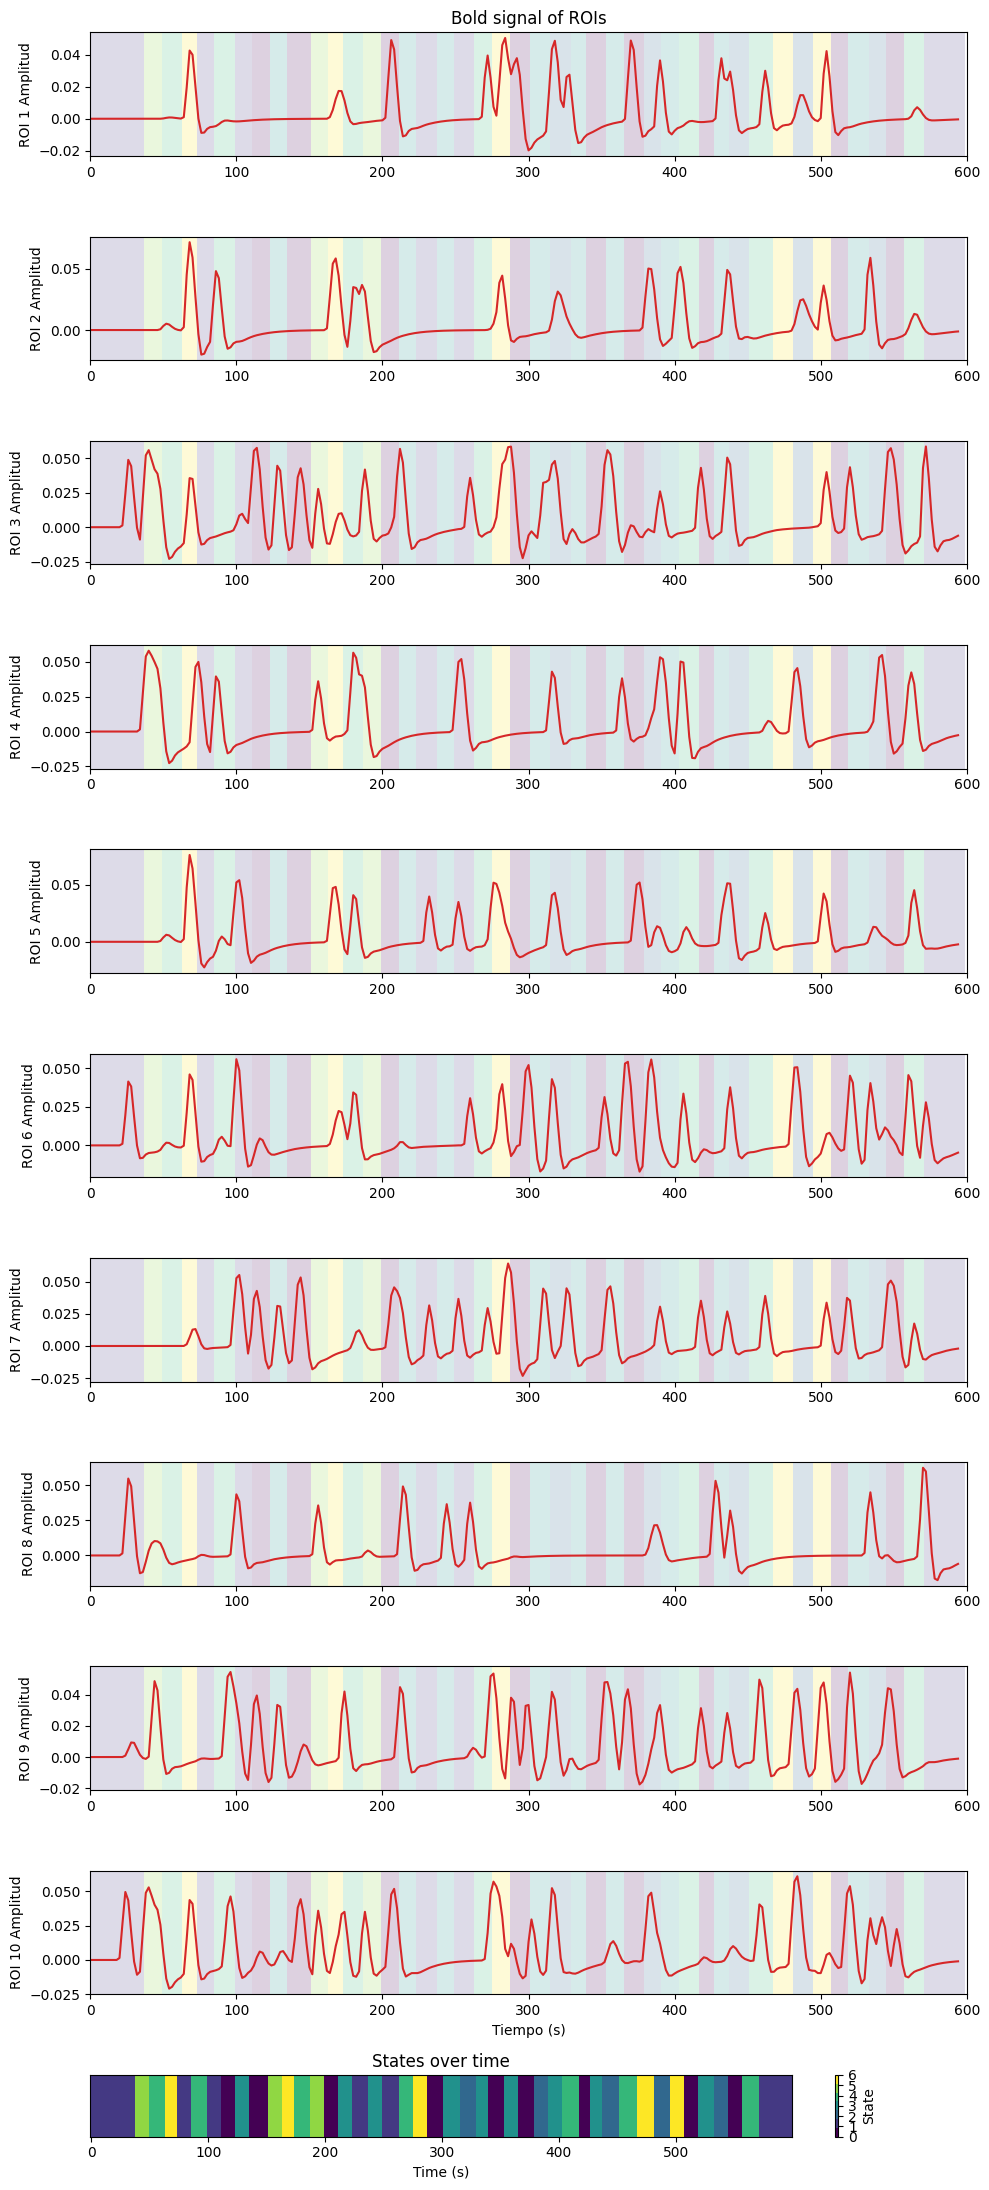

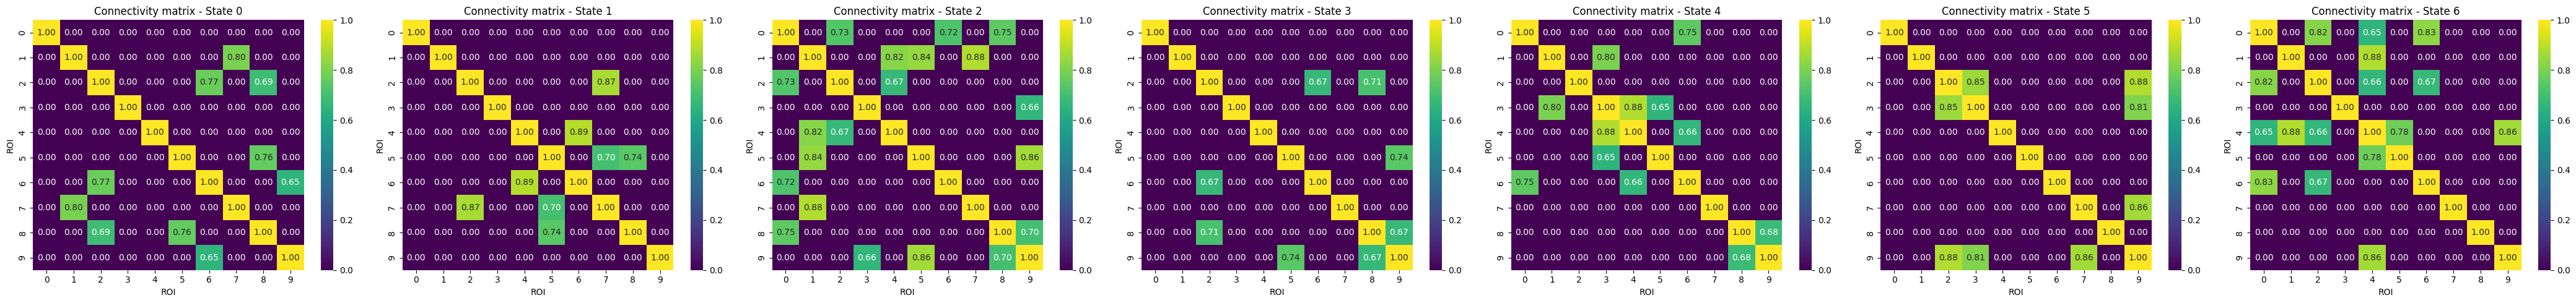

In [ ]:
for sub in range(1):
    timeline = data_list[sub]['timing']
    bold = data_list[sub]['bold']
    neur = data_list[sub]['neur']
    tbold = data_list[sub]['tbold']
    tneur = data_list[sub]['tneur']
    U = data_list[sub]['U']
    sample = data_list[sub]['sample']
    FC_states = data_list[sub]['FC_states']
    S = len(FC_states)
    _,D = bold.shape
    dyn_bmn.plot_signal_states(timeline, tsignal=tneur, signal = neur, D=D, S=S, FC_states=FC_states, sample=sample, TR=2, alpha=0.18, zorder=0, U=U, mode = "neur", shift=2)
    dyn_bmn.plot_signal_states(timeline, tsignal=tbold[:,0], signal = bold, D=D, S=S, FC_states=FC_states, sample=sample, TR=2, alpha=0.18, zorder=0, U=None, mode = "bold", shift=2)


/tmp/ipython-input-1650048610.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


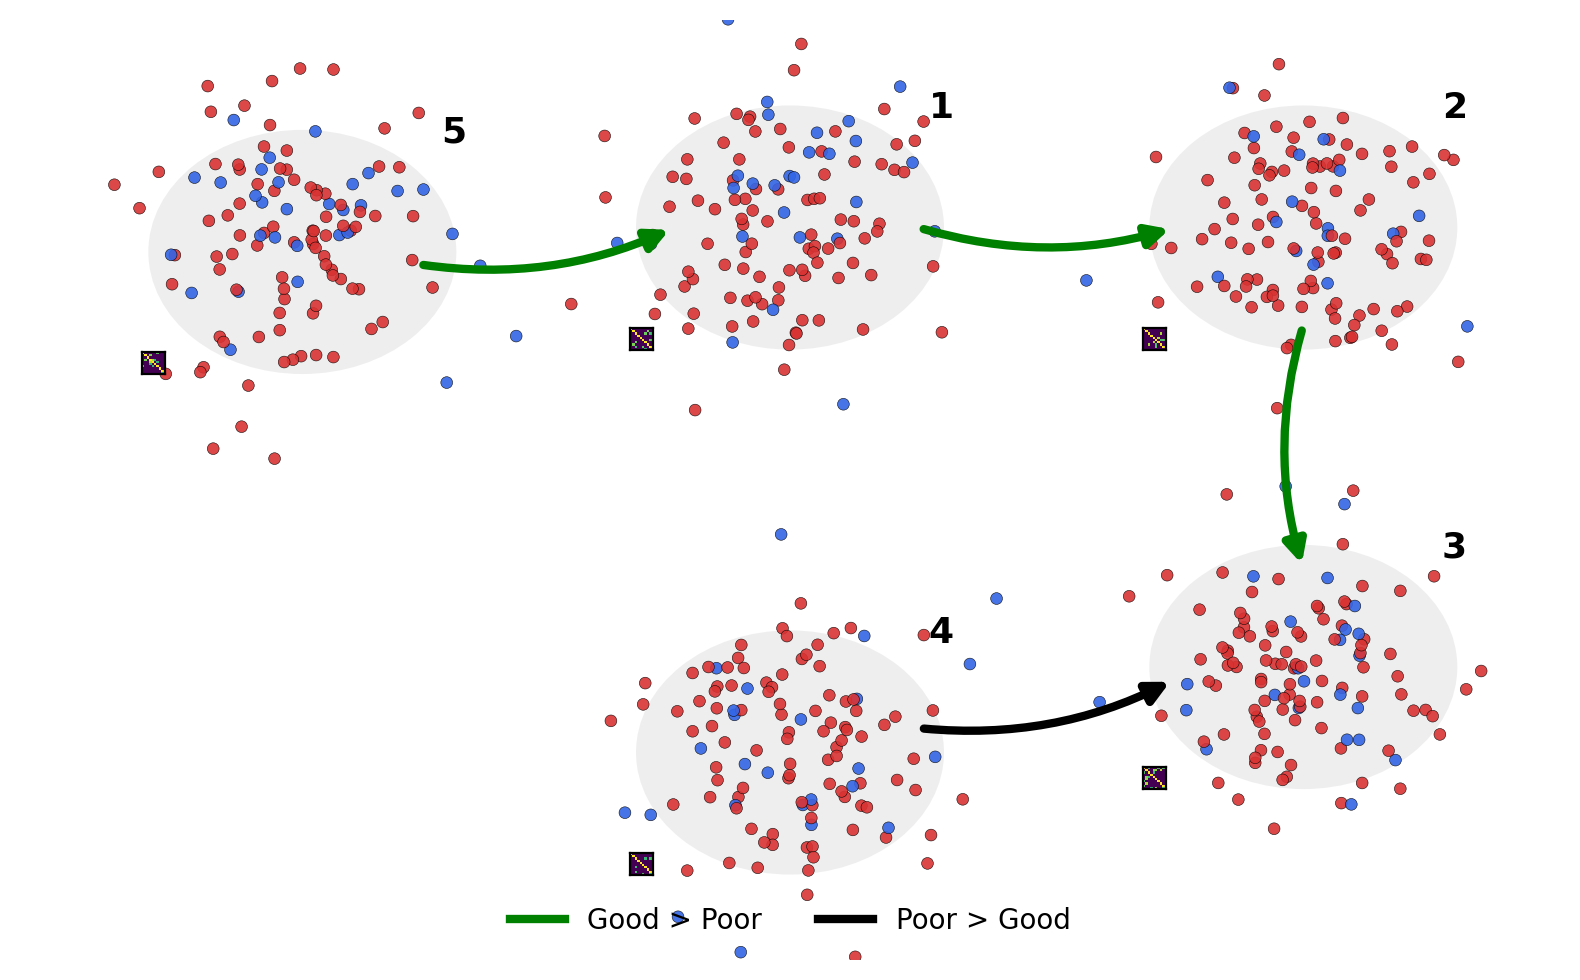

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------- utilidades ----------
def draw_state(ax, center, label, pts_xy, pts_color, matrix, bubble_size=(2.4, 2.0)):
    # “burbuja” translúcida
    e = Ellipse(xy=center, width=bubble_size[0], height=bubble_size[1],
                facecolor='#d0d0d0', edgecolor='none', alpha=0.35)
    ax.add_patch(e)

    # puntos dentro
    ax.scatter(pts_xy[:,0]+center[0], pts_xy[:,1]+center[1],
               s=18, c=pts_color, edgecolor='k', linewidths=0.2, alpha=0.9)

    # etiqueta del estado
    ax.text(center[0]+bubble_size[0]*0.45, center[1]+bubble_size[1]*0.45,
            str(label), fontsize=13, weight='bold')

    # inset con la matriz
    iax = inset_axes(ax, width="18%", height="18%",
                     bbox_to_anchor=(center[0]-bubble_size[0]*0.52,
                                     center[1]-bubble_size[1]*0.50, 1, 1),
                     bbox_transform=ax.transData, loc='lower left', borderpad=0)
    im = iax.imshow(matrix, interpolation='nearest', aspect='auto', cmap='viridis')
    iax.set_xticks([]); iax.set_yticks([])
    return im

def arrow(ax, p1, p2, color, lw=3, style='simple'):
    arr = FancyArrowPatch(p1, p2, arrowstyle='-|>', mutation_scale=16,
                          linewidth=lw, color=color, connectionstyle="arc3,rad=0.15")
    ax.add_patch(arr)

# ---------- datos de ejemplo (reemplaza por los tuyos) ----------
rng = np.random.default_rng(0)
matrices = FC_states1[:5]
# posiciones de cada “estado”
centers = [(0,3.5), (4,3.5), (4,-0.1), (0,-0.8), (-3.8,3.3)]
# nubes de puntos para cada burbuja
def make_cloud(n=120):
    # nube compacta con forma orgánica
    r = rng.normal(0, 0.6, (n,2))
    # un poco de “hueco” interno
    r *= 0.9 + 0.2*rng.random((n,1))
    return r
clouds = [make_cloud() for _ in range(5)]

# colores de puntos (rojo vs azul) – ajusta la proporción a lo que necesites
colors = []
for k in range(5):
    mask = rng.random(len(clouds[k])) > 0.75
    c = np.where(mask[:,None], np.array([[0.2,0.4,0.9]]), np.array([[0.85,0.2,0.2]]))
    colors.append(c)

# ---------- figura ----------
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
ims = []
for i in range(5):
    im = draw_state(ax, centers[i], i+1, clouds[i], colors[i], matrices[i])
    ims.append(im)

# flechas (ajusta sentidos y colores)
arrow(ax, (centers[0][0]+1.0, centers[0][1]), (centers[1][0]-1.0, centers[1][1]), color='green')
arrow(ax, (centers[1][0], centers[1][1]-0.8), (centers[2][0], centers[2][1]+0.8), color='green')
arrow(ax, (centers[3][0]+1.0, centers[3][1]+0.2), (centers[2][0]-1.0, centers[2][1]-0.1), color='black')
arrow(ax, (centers[4][0]+0.9, centers[4][1]-0.1), (centers[0][0]-0.9, centers[0][1]), color='green')

# estética general
ax.set_xlim(-6, 6); ax.set_ylim(-2.5, 5.2)
ax.axis('off')

# mini-leyenda de flechas
ax.plot([], [], color='green', linewidth=3, label='Good > Poor')
ax.plot([], [], color='black', linewidth=3, label='Poor > Good')
ax.legend(loc='lower center', ncol=2, frameon=False)

plt.tight_layout()
plt.show()


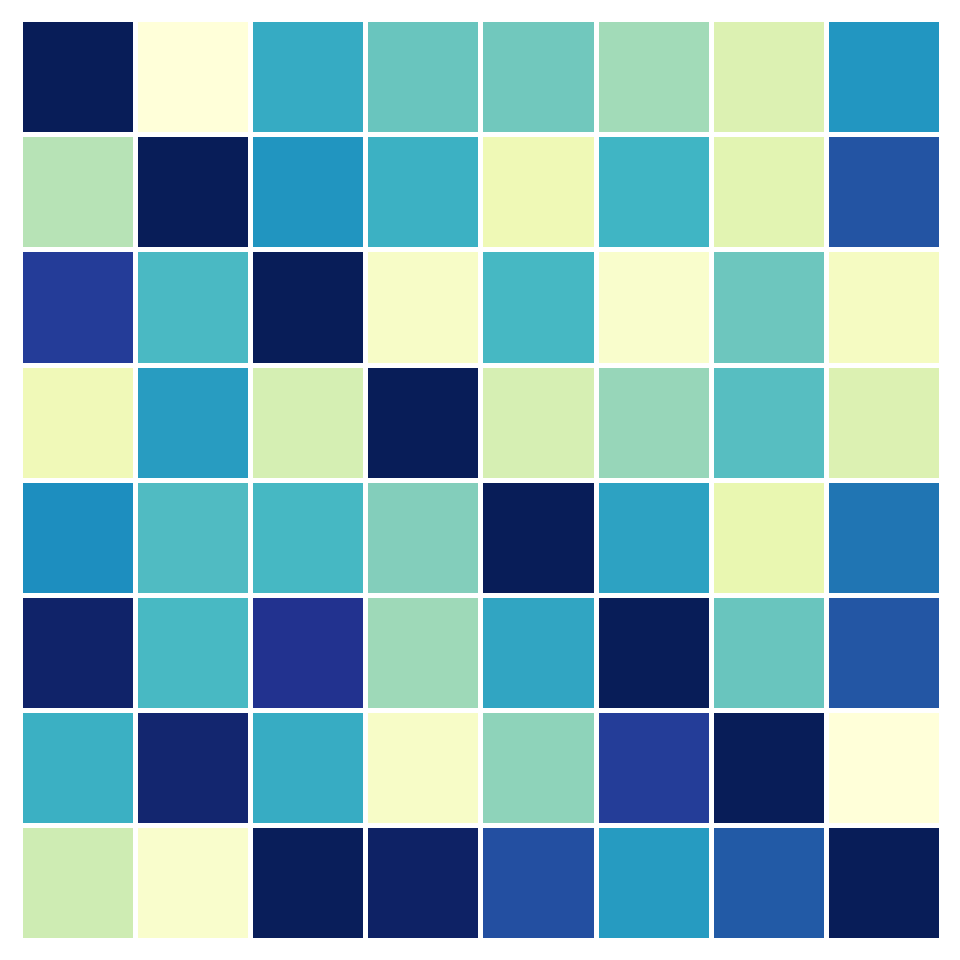

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generar una matriz aleatoria similar
np.random.seed(2)
A = np.random.rand(8, 8)
#A[A < 0.7] = np.nan  # simula celdas vacías / bajas
np.fill_diagonal(A, 1)  # eliminar la diagonal principal

# Colormap azulado tipo paper
cmap = sns.color_palette("YlGnBu", as_cmap=True)

plt.figure(figsize=(5,5), dpi=200)
sns.heatmap(
    A,
    cmap=cmap,
    square=True,
    linewidths=1.2,
    linecolor='white',
    cbar=False
)

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()
